# Decadal Trends and Popularity Patterns in Spotify Music: A Cluster-Based Feature Analysis - Alrick Gicole

CELL 1: Importing Libraries and Setting Up the Environment

In [15]:
#CELL 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


CELL 2: Initial Data Loading and Exploration
Markdown Explanation:
In this cell, we load the Spotify dataset and perform an initial exploratory data analysis (EDA). We print the first few rows, check the dataset’s info, and generate some summary statistics. We then plot initial distributions and correlation heatmaps to understand the data better. We also identify potential outliers and duplicates, and report missing values.

Initial Data Snapshot:
                       id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  lo

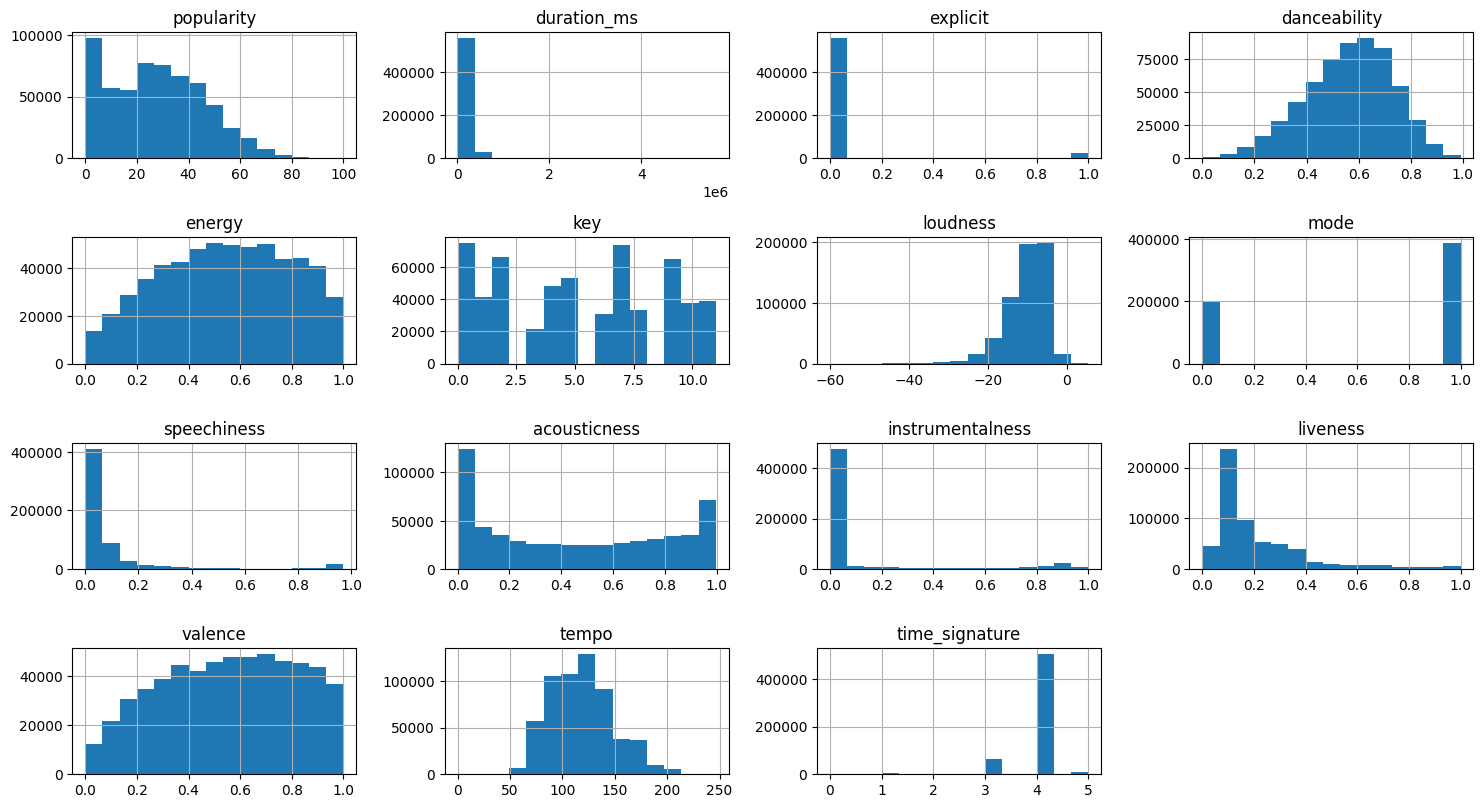

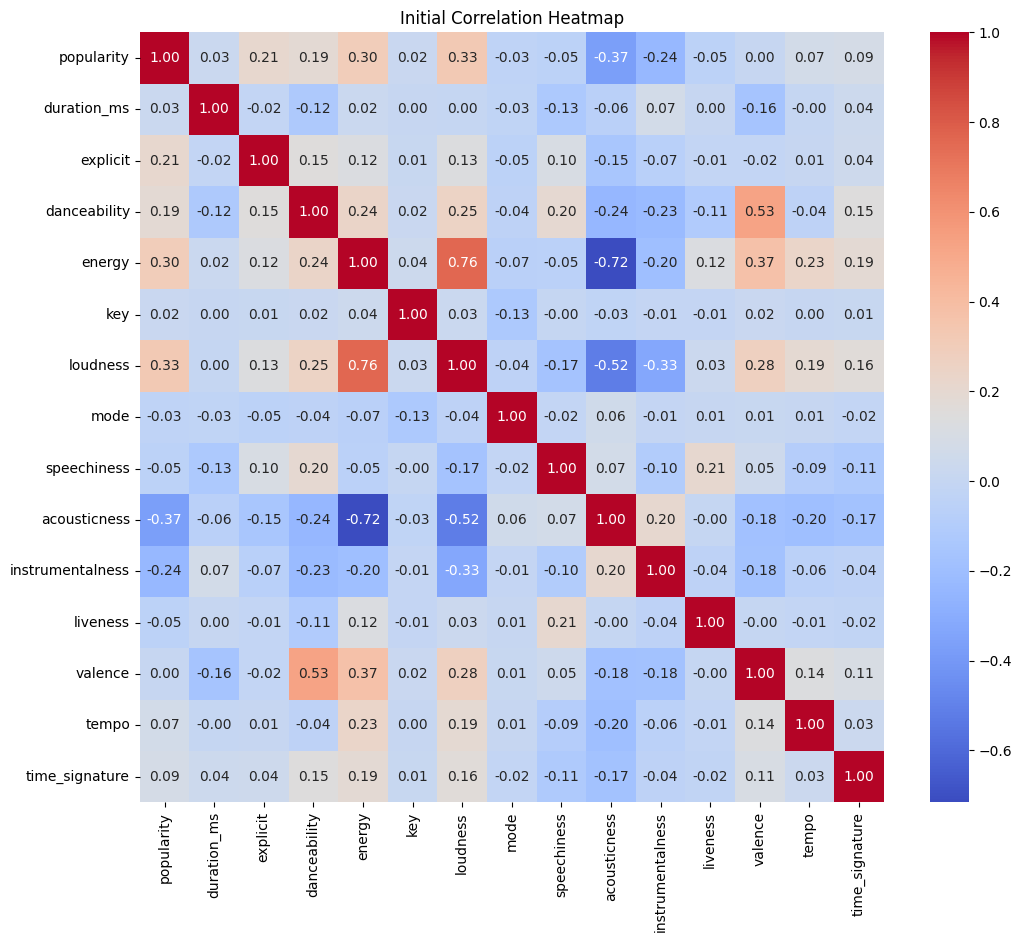

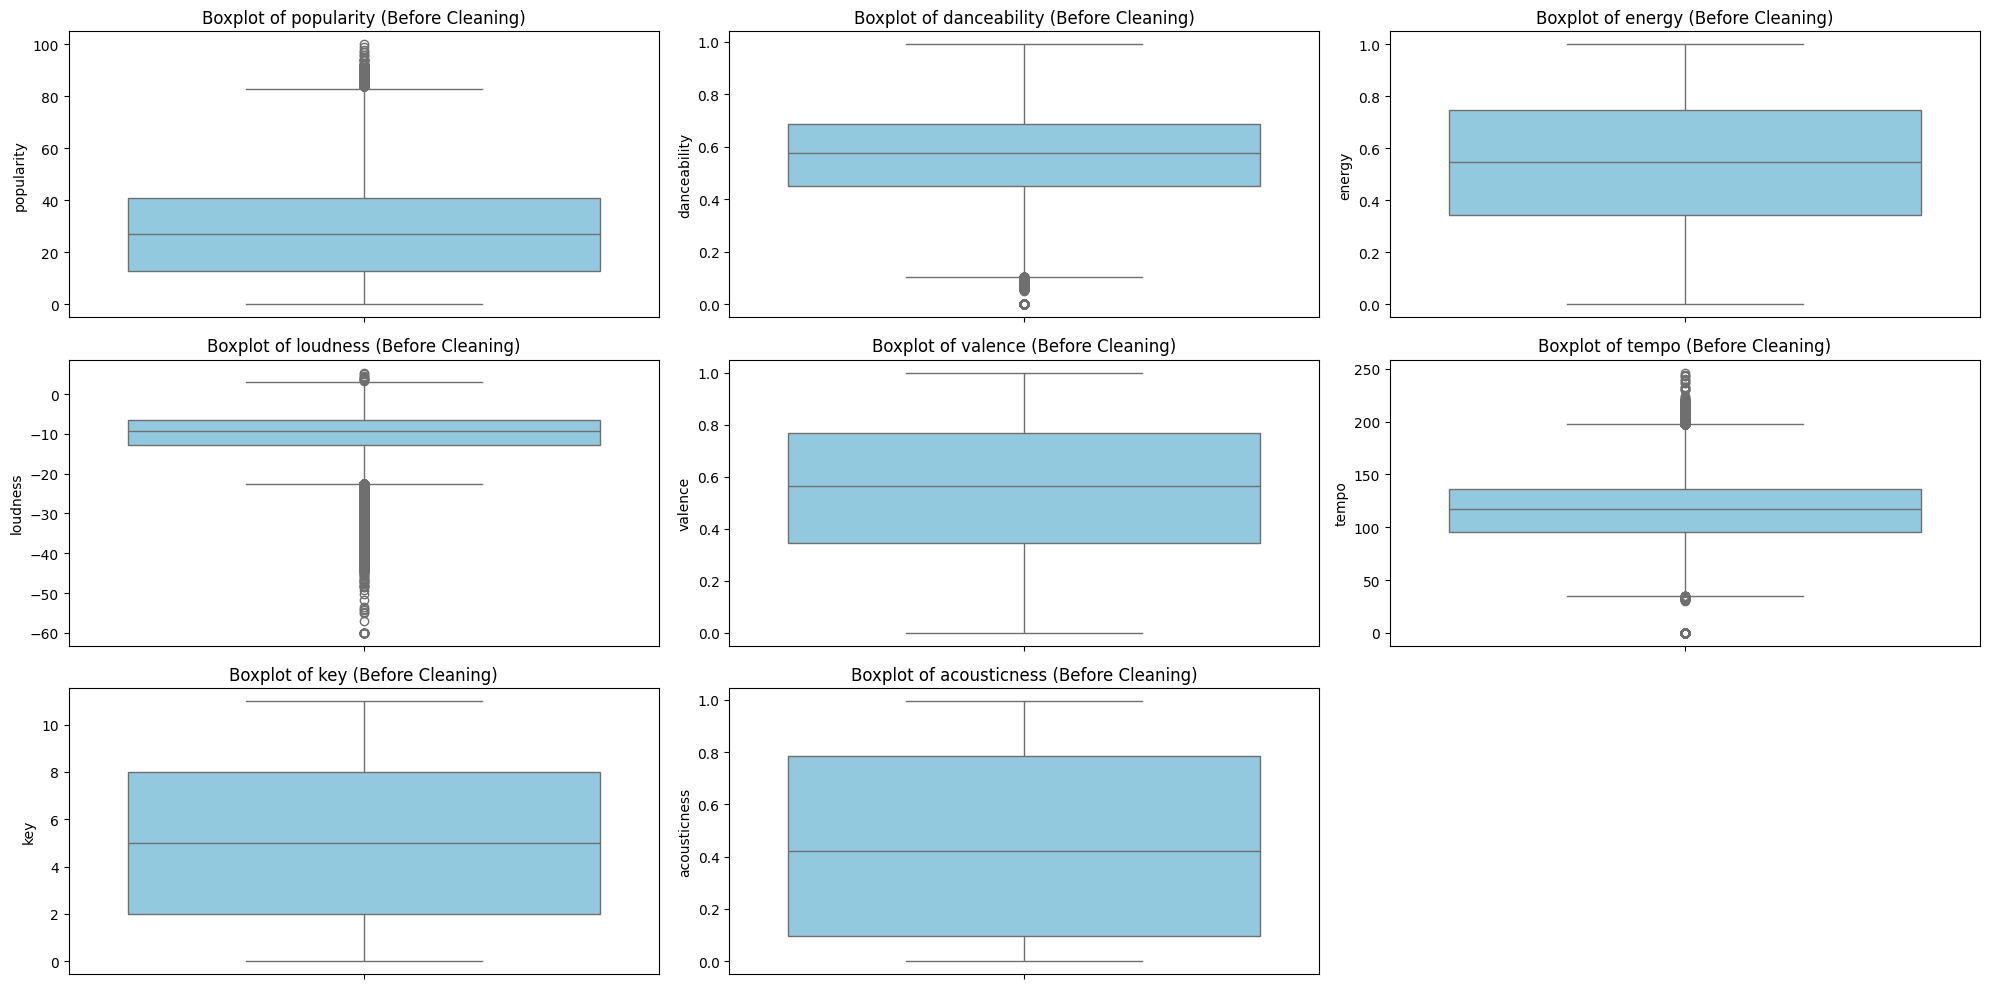

### Summary of Inconsistencies


,Metric,Count
0,Popularity = 0 Tracks,44690
1,Duplicate Rows,0


### Missing Values by Column


,Column,Missing Values
1,name,71


In [16]:
#CELL 2
# ----------------------------------------------------------
# 1. Load the Dataset
# ----------------------------------------------------------
spotify = pd.read_csv('spotify.csv')

# Initial EDA on Raw Data
print("Initial Data Snapshot:")
print(spotify.head())

print("\nInitial Data Info:")
print(spotify.info())

print("\nInitial Statistical Summary:")
print(spotify.describe())

# Plot initial distributions
numerical_cols = spotify.select_dtypes(include=['number']).columns
spotify[numerical_cols].hist(bins=15, figsize=(15, 10), layout=(5, 4))
plt.tight_layout()
plt.show()

# Initial Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = spotify[numerical_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Initial Correlation Heatmap')
plt.show()

# Initial Boxplots to Identify Outliers
key_features = ['popularity', 'danceability', 'energy', 'loudness', 'valence', 'tempo', 'key', 'acousticness']
plt.figure(figsize=(20, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=spotify[feature], color='skyblue')
    plt.title(f'Boxplot of {feature} (Before Cleaning)')
plt.tight_layout()
plt.show()

# Count of tracks with popularity = 0
pop_zero_count = spotify[spotify['popularity'] == 0].shape[0]

# Count of duplicate rows
duplicate_count = spotify.duplicated().sum()

# Count of missing values per column
missing_values = spotify.isnull().sum()

# Create a summary table for Popularity = 0 and Duplicates
summary_data = {
    'Metric': ['Popularity = 0 Tracks', 'Duplicate Rows'],
    'Count': [pop_zero_count, duplicate_count]
}
summary_table = pd.DataFrame(summary_data)

print("### Summary of Inconsistencies")
display(summary_table)

# Create a detailed table for Missing Values per Column
missing_data = {
    'Column': missing_values.index,
    'Missing Values': missing_values.values
}
missing_table = pd.DataFrame(missing_data)
missing_table = missing_table[missing_table['Missing Values'] > 0]  # Filter columns with missing values

print("### Missing Values by Column")
display(missing_table)


**Note on Outliers:**  
We initially explored removing outliers to clean the dataset further. However, we decided not to use the outlier-removed dataset for this research. Our rationale is that the inherent diversity of songs might be important and meaningful, and removing these points could bias our analysis. Thus, we retained outliers to reflect the true variability in music characteristics.


In [17]:
# ----------------------------------------------------------
# 3. Outlier Detection and Removal (Z-Score Method Only)
# ----------------------------------------------------------

from scipy import stats

# Identify numerical columns for outlier removal
numerical_cols = spotify.select_dtypes(include=[np.number]).columns

# Calculate Z-Scores
z_scores = np.abs(stats.zscore(spotify[numerical_cols]))

# Define a threshold
threshold = 3

# Identify outliers
outliers = (z_scores > threshold).any(axis=1)

print(f"Number of outliers to remove: {outliers.sum()}")

# Remove outliers
spotify_cleaned = spotify[~outliers]
print(f"Shape after removing outliers: {spotify_cleaned.shape}")


Number of outliers to remove: 91018
Shape after removing outliers: (495654, 20)


CELL 3: Data Preprocessing
Markdown Explanation:
Here, we clean the dataset by removing unnecessary columns (like IDs and names), dropping missing values and duplicates, and filtering out tracks with zero popularity. We also extract the release year from the release_date and create derived features like age and decade. At the end of this step, we have a cleaner dataset ready for further analysis.

In [18]:
#CELL 3

# ----------------------------------------------------------
# 2. Data Preprocessing
# ----------------------------------------------------------

# Columns to remove
columns_to_remove = ['id', 'id_artists', 'name', 'artists']
spotify.drop(columns=columns_to_remove, inplace=True)

# Remove rows with missing values, duplicates, and popularity = 0
spotify = spotify.dropna().drop_duplicates()
spotify = spotify[spotify['popularity'] > 0]

# Function to extract the year from release_date
def extract_year(date):
    try:
        date = str(date)
        if '/' in date:
            return int(date.split('/')[-1])
        elif '-' in date:
            return int(date.split('-')[0])
        else:
            return int(date)
    except Exception as e:
        print(f"Error processing date: {date}, Error: {e}")
        return None

# Apply the function to extract year
spotify['release_year'] = spotify['release_date'].apply(extract_year)
spotify.dropna(subset=['release_year'], inplace=True)
spotify = spotify[spotify['release_year'] < 2021]

import datetime
current_year = datetime.datetime.now().year
spotify['age'] = current_year - spotify['release_year']
spotify['decade'] = (spotify['release_year'] // 10) * 10
spotify.drop(columns=['release_date', 'release_year'], inplace=True)

# One-hot encode any remaining categorical variables
categorical_cols = spotify.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    spotify = pd.get_dummies(spotify, drop_first=True)

print(f"Shape of dataset after preprocessing: {spotify.shape}")
print(spotify.head())





Shape of dataset after preprocessing: (536605, 17)
     popularity  duration_ms  explicit  danceability  energy  key  loudness  \
0             6       126903         0         0.645  0.4450    0   -13.338   
13            1       186800         0         0.703  0.2800    0   -15.390   
26            4       180800         0         0.420  0.2880    7   -14.005   
149          41       177133         0         0.614  0.0423    4   -12.033   
150          38       161933         0         0.831  0.2620    8   -12.386   

     mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0       1       0.4510         0.674          0.744000     0.151    0.127   
13      1       0.1740         0.995          0.000068     0.163    0.897   
26      1       0.0701         0.994          0.000216     0.196    0.400   
149     1       0.0535         0.996          0.002930     0.183    0.211   
150     1       0.0942         0.984          0.912000     0.204    0.901   

       temp

CELL 4: Post-Preprocessing EDA (Commented Outlier Removal Steps)
Markdown Explanation:
This cell was intended to visualize the dataset after outlier removal. Since we decided to keep outliers, the code related to spotify_cleaned should be considered exploratory only and is not executed. We keep the code here commented out for reference.

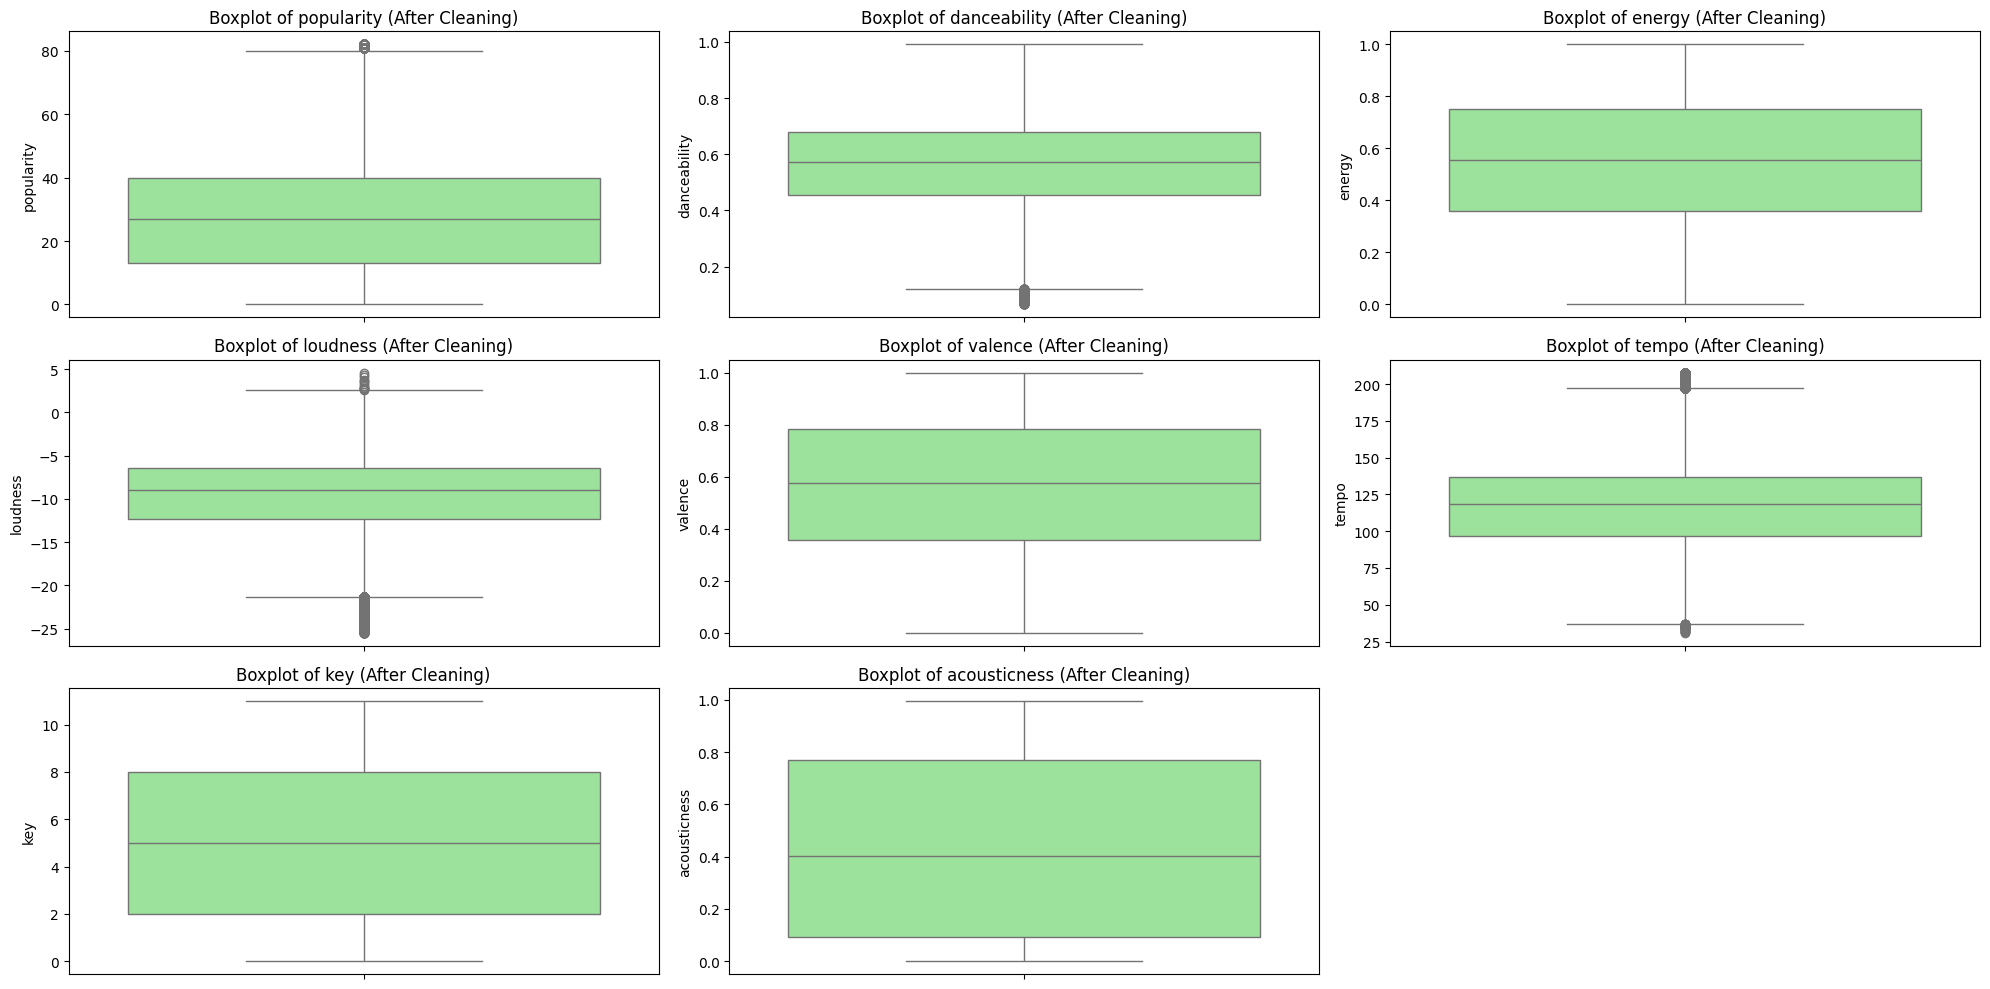

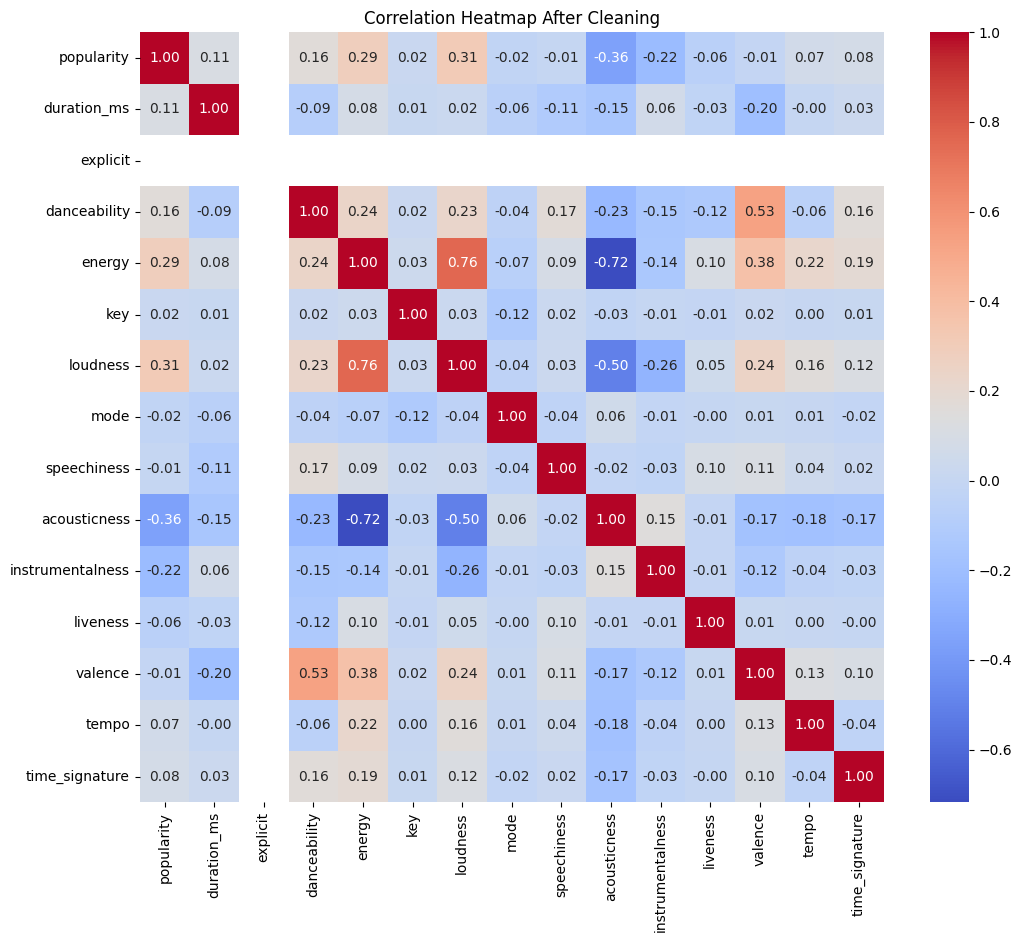

In [19]:
#CELL 4
# ----------------------------------------------------------
# 4. Post-Preprocessing EDA
# ----------------------------------------------------------

# Visualization After Outlier Removal (Z-Score Method Results)
plt.figure(figsize=(20, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=spotify_cleaned[feature], color='lightgreen')
    plt.title(f'Boxplot of {feature} (After Cleaning)')
plt.tight_layout()
plt.show()

# Updated Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = spotify_cleaned[numerical_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap After Cleaning')
plt.show()

# # Additional Visualization: Scatter Plots Without Outlier Identification
# plt.figure(figsize=(15, 10))
# for i, feature in enumerate(key_features, 1):
#     plt.subplot(3, 3, i)
#     sns.scatterplot(x=spotify_cleaned.index, y=spotify_cleaned[feature], color='blue', label='Data Points', alpha=0.5)
#     plt.title(f'Scatter Plot of {feature}')
#     plt.xlabel('Index')
#     plt.ylabel(feature.capitalize())
#     plt.legend()
# plt.tight_layout()
# plt.show()


CELL 5: Feature Scaling
Markdown Explanation:
We apply standardization to numerical features to ensure that all attributes have similar scales before clustering. This step helps K-Means focus on differences in feature patterns rather than magnitude.

In [20]:
#CELL 5
# Identify numerical columns
numerical_cols = spotify.select_dtypes(include=['float64', 'int64']).columns

# Initialize the scaler
scaler = StandardScaler()

# Create a scaled copy of the dataset
X_scaled = spotify.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X_scaled[numerical_cols])

print("Feature scaling completed.")


Feature scaling completed.


CELL 6: Determining Optimal Number of Clusters (Elbow Method)
Markdown Explanation:
We use the Elbow Method to decide how many clusters to choose for K-Means. The plot helps identify a point (the "elbow") where adding more clusters doesn’t significantly improve the explained variance.

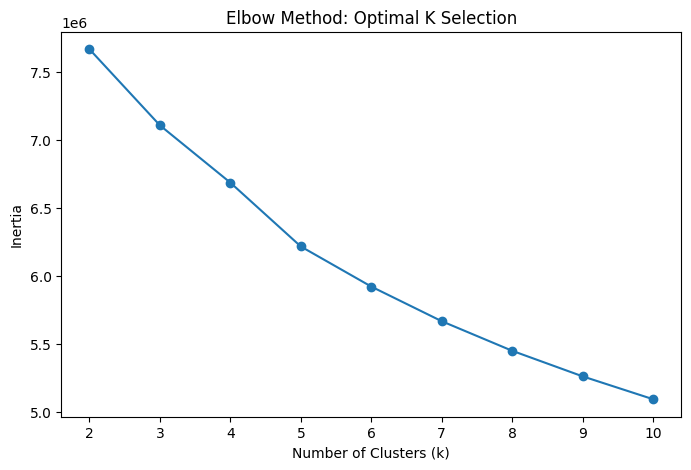

In [21]:
# Cell 6: Determine Optimal Number of Clusters using the Elbow Method

inertias = []
K_values = range(2, 11)  # You can adjust this range as needed

# We'll run K-Means for each k and record the inertia
for k in K_values:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(X_scaled[numerical_cols])  # Ensure you're using the same scaled numerical data as before
    inertias.append(kmeans_test.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_values, inertias, marker='o')
plt.title('Elbow Method: Optimal K Selection')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_values)
plt.show()

# Based on this plot, select the k where the "elbow" appears and then set num_clusters accordingly in the next cell.


CELL 7: Applying K-Means Clustering
Markdown Explanation:
Based on the Elbow Method, we select k=4 clusters. We then apply K-Means to the scaled dataset and add the cluster labels to the original data.

In [22]:
#CELL 7
# Define the number of clusters
num_clusters = 4

# Initialize KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans and assign cluster labels
X_scaled['Cluster'] = kmeans.fit_predict(X_scaled[numerical_cols])

# Add cluster information to the original dataframe
spotify_with_clusters = spotify.copy()
spotify_with_clusters['Cluster'] = X_scaled['Cluster']

print("K-Means clustering completed.")


K-Means clustering completed.


CELL 8: Cluster Analysis and Visualization
Markdown Explanation:
We examine the average feature values for each cluster and visualize cluster characteristics using a violin plot for popularity and a radar chart for core audio features. We also show how clusters differ by decade.

Cluster Means:
         popularity    duration_ms  explicit  danceability    energy  \
Cluster                                                                
0         46.339387  221136.102006  1.000000      0.678701  0.690417   
1         36.692847  242448.011582  0.000000      0.597194  0.699323   
2         21.864024  255801.794289  0.000177      0.405679  0.250983   
3         19.487252  189898.194992  0.000043      0.609992  0.495421   

              key   loudness      mode  speechiness  acousticness  \
Cluster                                                             
0        5.424202  -6.949988  0.548412     0.189113      0.203992   
1        5.378869  -7.305438  0.626793     0.067611      0.230860   
2        5.021382 -15.545569  0.675058     0.048166      0.773941   
3        5.052113 -11.346348  0.720947     0.191363      0.566013   

         instrumentalness  liveness   valence       tempo  time_signature  \
Cluster                                                     

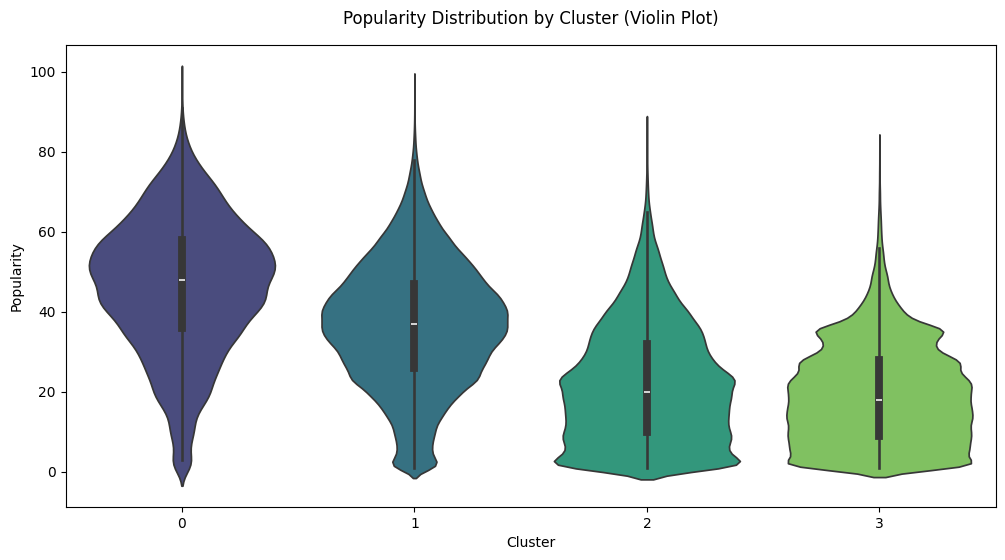

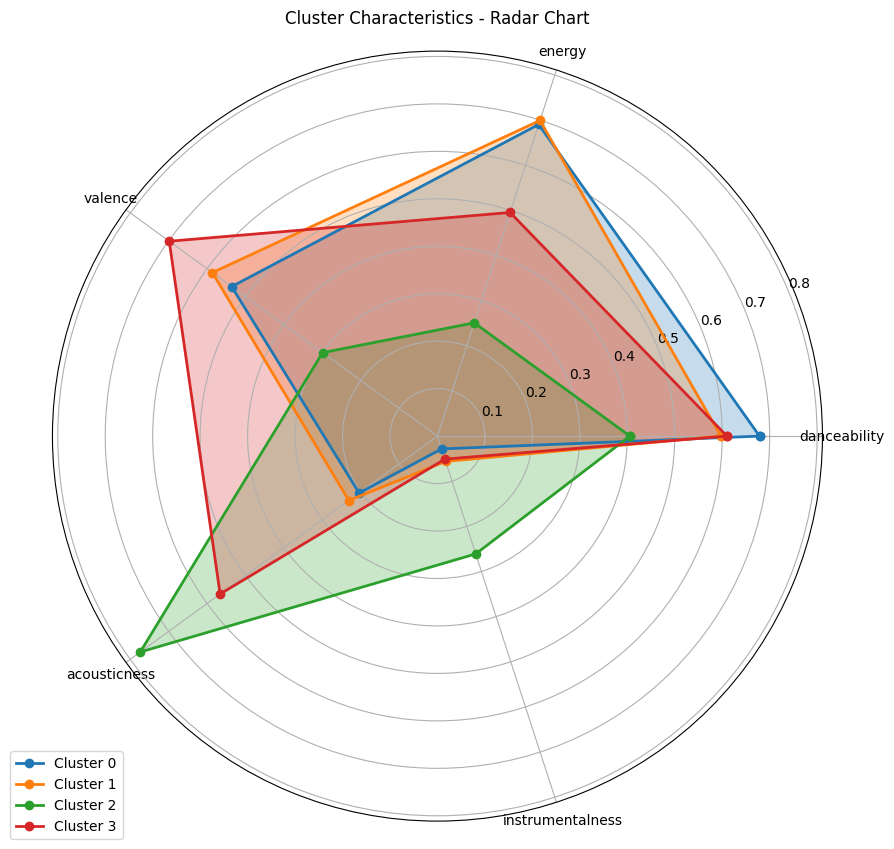

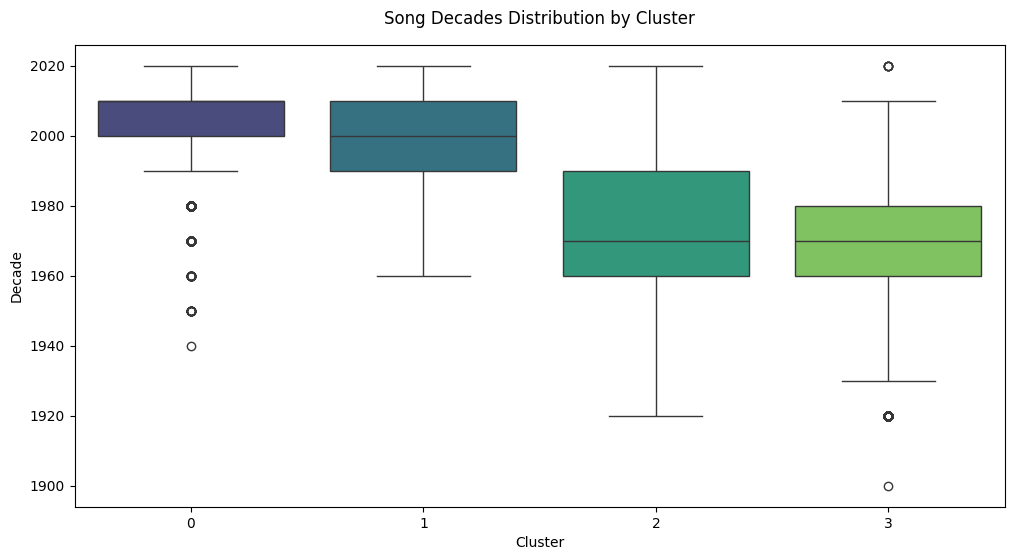

In [23]:
#CELL 8
# Use a built-in style
plt.style.use('default')  # or try 'ggplot', 'fivethirtyeight', etc.

# Calculate mean of features for each cluster
cluster_means = spotify_with_clusters.groupby('Cluster').mean()
print("Cluster Means:")
print(cluster_means)

# 1. Enhanced Popularity Distribution
plt.figure(figsize=(12, 6))
sns.violinplot(x='Cluster', y='popularity', data=spotify_with_clusters, palette='viridis')
plt.title('Popularity Distribution by Cluster (Violin Plot)', fontsize=12, pad=15)
plt.xlabel('Cluster')
plt.ylabel('Popularity')
plt.show()

# 2. Radar chart for key features
features = ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness']
angles = np.linspace(0, 2*np.pi, len(features), endpoint=False)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
for cluster in range(num_clusters):
    values = cluster_means.loc[cluster, features].values
    values = np.concatenate((values, [values[0]]))
    angles_plot = np.concatenate((angles, [angles[0]]))
    ax.plot(angles_plot, values, 'o-', linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles_plot, values, alpha=0.25)

ax.set_xticks(angles)
ax.set_xticklabels(features)
ax.set_title('Cluster Characteristics - Radar Chart', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

# 3. Temporal distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='decade', data=spotify_with_clusters, palette='viridis')
plt.title('Song Decades Distribution by Cluster', fontsize=12, pad=15)
plt.xlabel('Cluster')
plt.ylabel('Decade')
plt.show()


CELL 9: Cluster Sizes and Centers
Markdown Explanation:
We inspect the size of each cluster, check the cluster centers in scaled form, and then inverse-transform them back to the original scale for interpretation.

In [24]:
#CELL 9
# Cluster Sizes
cluster_sizes = spotify_with_clusters['Cluster'].value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_sizes)

# Cluster Centers in Scaled Space
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=numerical_cols)
print("\nCluster Centers (Scaled):")
print(cluster_centers)

# Inverse Transform to Original Scale
original_centers_numerical = scaler.inverse_transform(kmeans.cluster_centers_)
original_centers_df = pd.DataFrame(original_centers_numerical, columns=numerical_cols)
print("\nCluster Centers (Original Scale):")
print(original_centers_df)


Cluster Sizes:
Cluster
0     23734
1    267235
2    107379
3    138257
Name: count, dtype: int64

Cluster Centers (Scaled):
   popularity  duration_ms  explicit  danceability    energy       key  \
0    0.972104    -0.080399  4.646002      0.686977  0.541832  0.056534   
1    0.408163     0.099954 -0.215239      0.190960  0.577672  0.043717   
2   -0.460234     0.213141 -0.214376     -0.975460 -1.240096 -0.057952   
3   -0.597883    -0.343544 -0.215028      0.267599 -0.248686 -0.049203   

   loudness      mode  speechiness  acousticness  instrumentalness  liveness  \
0  0.615902 -0.229297     0.506930     -0.655612         -0.270404 -0.054662   
1  0.543682 -0.064170    -0.191935     -0.575540         -0.157021 -0.034505   
2 -1.133984  0.037771    -0.303613      1.039009          0.683165 -0.167397   
3 -0.277794  0.133802     0.517708      0.419364         -0.178611  0.205167   

    valence     tempo  time_signature       age    decade  
0 -0.075871  0.001792        0.203927 -0.977

CELL 10: Decade-by-Decade Analysis
Markdown Explanation:
We analyze how cluster characteristics vary across decades. We sort clusters within each decade based on popularity and visualize trends over time. This helps us understand which cluster profiles remain popular or become popular over the years.


Mean Values by Decade and Sorted Cluster:
    decade  Sorted_Cluster  Cluster  popularity    duration_ms  explicit  danceability    energy       key   loudness      mode  speechiness  acousticness  instrumentalness  liveness   valence       tempo  time_signature        age
0     1920               0      2.0    6.822500  239996.482500  0.000000      0.435553  0.158206  4.772500 -17.167552  0.737500     0.051713      0.964760          0.537018  0.183981  0.329168   99.471252        3.760000  97.397500
1     1920               1      3.0    4.589327  163513.190255  0.002320      0.674146  0.264713  5.694509 -15.049483  0.717711     0.383399      0.764528          0.184071  0.213785  0.586895  118.137585        3.842227  98.066512
2     1920               2      NaN         NaN            NaN       NaN           NaN       NaN       NaN        NaN       NaN          NaN           NaN               NaN       NaN       NaN         NaN             NaN        NaN
3     1920               3   

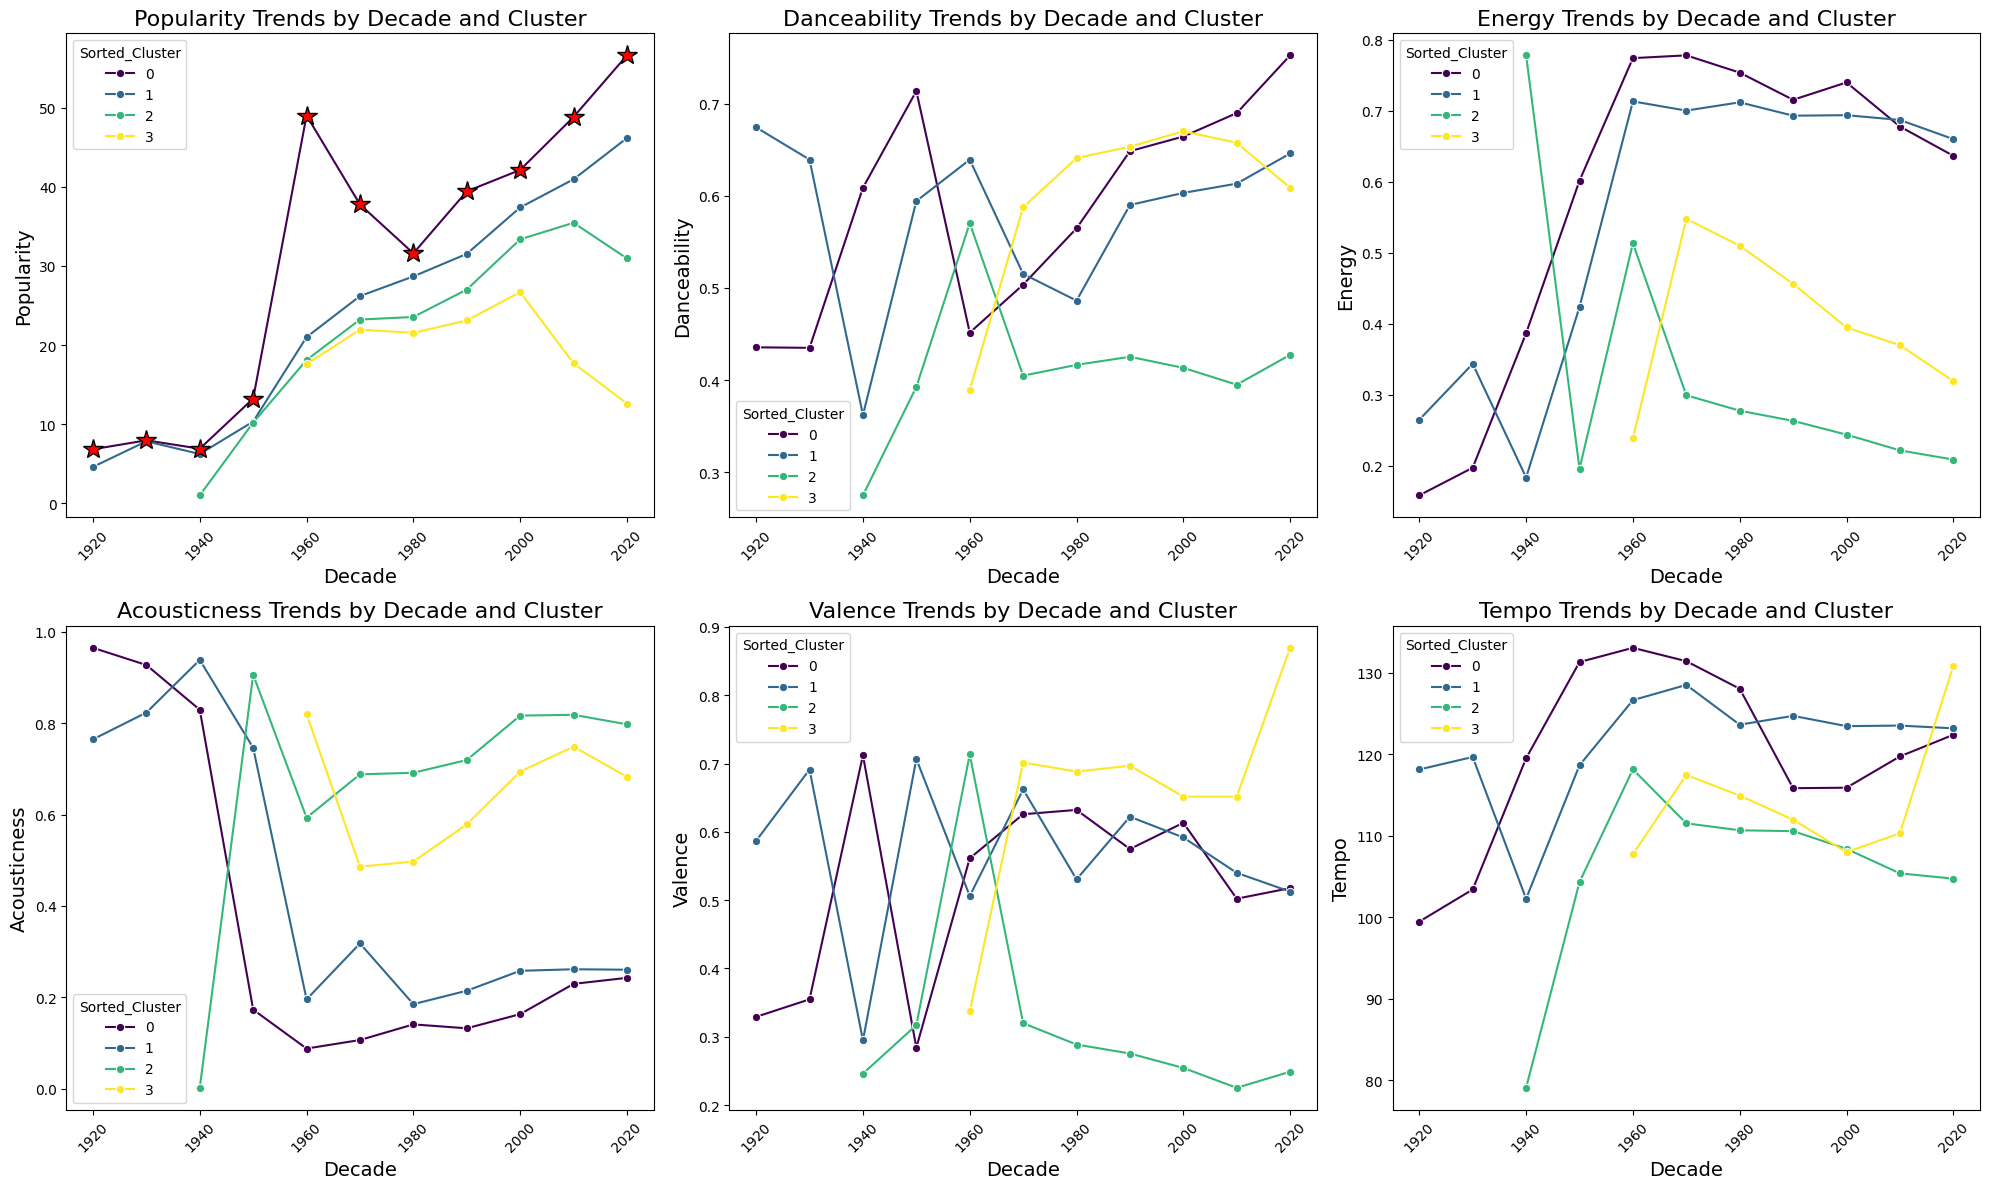

In [25]:
#CELL 10
# Assuming spotify_with_clusters is already defined and includes 'decade' and 'Cluster' columns

X_with_clusters = spotify_with_clusters.copy()
X_with_clusters = X_with_clusters[X_with_clusters['decade'] != 1900]

# Group by decade and cluster to compute mean values
decade_cluster_means = X_with_clusters.groupby(['decade', 'Cluster']).mean()

# Sort clusters within each decade based on popularity
decade_cluster_sorted = decade_cluster_means.reset_index().sort_values(['decade', 'popularity'], ascending=[True, False])

# Assign new cluster labels based on sorted popularity
decade_cluster_sorted['Sorted_Cluster'] = decade_cluster_sorted.groupby('decade').cumcount()

# Create a mapping from (decade, old_cluster) to new_sorted_cluster
cluster_mapping = decade_cluster_sorted.set_index(['decade', 'Cluster'])['Sorted_Cluster'].to_dict()

# Map the new sorted cluster labels to the original DataFrame
X_with_clusters['Sorted_Cluster'] = X_with_clusters.apply(
    lambda row: cluster_mapping.get((row['decade'], row['Cluster'])), axis=1
)

# Update decade_cluster_means_reset with Sorted_Cluster
decade_cluster_means_reset = decade_cluster_means.reset_index()
decade_cluster_means_reset['Sorted_Cluster'] = decade_cluster_means_reset.apply(
    lambda row: cluster_mapping.get((row['decade'], row['Cluster'])), axis=1
)

# Ensure all combinations of decades and sorted clusters exist
all_decades = decade_cluster_means_reset['decade'].unique()
all_sorted_clusters = decade_cluster_sorted['Sorted_Cluster'].unique()

full_index = pd.MultiIndex.from_product(
    [all_decades, all_sorted_clusters],
    names=['decade', 'Sorted_Cluster']
)
decade_cluster_full = decade_cluster_means_reset.set_index(['decade', 'Sorted_Cluster']).reindex(full_index).reset_index()

# Now, to reflect the correct ordering when printing, you can sort by decade and Sorted_Cluster:
decade_cluster_full = decade_cluster_full.sort_values(['decade', 'Sorted_Cluster'], ascending=[True, True])

# Print the mean values in the new order
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
print("\nMean Values by Decade and Sorted Cluster:")
print(decade_cluster_full)


# # Existing boxplot for popularity distribution by decade and sorted cluster
# plt.figure(figsize=(14, 8))
# ax = sns.boxplot(x='decade', y='popularity', hue='Sorted_Cluster', data=X_with_clusters, palette='viridis')
# plt.xticks(rotation=45)
# plt.title('Popularity Distribution by Decade and Cluster', fontsize=16)
# plt.xlabel('Decade', fontsize=14)
# plt.ylabel('Popularity', fontsize=14)
# plt.tight_layout()
# plt.show()

# ----------------------------------------------------------
# NEW: Combine line plots to visualize changes over decades
# ----------------------------------------------------------
features_to_plot = ['popularity', 'danceability', 'energy', 'acousticness', 'valence', 'tempo']

# Compute max popularity per decade to know where to place the star
max_pop = decade_cluster_full.groupby('decade')['popularity'].max().reset_index()
max_pop.rename(columns={'popularity': 'max_popularity'}, inplace=True)

# Merge this max popularity info back to identify which cluster and feature combination to highlight
decade_cluster_star = pd.merge(decade_cluster_full, max_pop, on='decade', how='left')
# Filter rows that match the max popularity for that decade
decade_cluster_star = decade_cluster_star[decade_cluster_star['popularity'] == decade_cluster_star['max_popularity']]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    # Plot the line for all sorted clusters
    sns.lineplot(
        x='decade',
        y=feature,
        hue='Sorted_Cluster',
        data=decade_cluster_full,
        marker='o',
        palette='viridis',
        ax=axes[i]
    )
    
    # For popularity feature, add a star at the max point
    if feature == 'popularity':
        for _, row in decade_cluster_star.iterrows():
            axes[i].plot(
                row['decade'], 
                row['popularity'], 
                marker='*', 
                markersize=15, 
                markerfacecolor='red', 
                markeredgecolor='black', 
                zorder=10
            )
    
    axes[i].set_title(f'{feature.capitalize()} Trends by Decade and Cluster', fontsize=16)
    axes[i].set_xlabel('Decade', fontsize=14)
    axes[i].set_ylabel(feature.capitalize(), fontsize=14)
    
    # Rotate x-ticks for better readability
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)


plt.tight_layout()
plt.show()

CELL 11: Popularity Bins Analysis
Markdown Explanation:
We divide tracks into popularity bins and analyze their average feature values. This provides another viewpoint on how features differ based on a track’s commercial success.

Feature Differences by Popularity Bins:
                popularity    duration_ms  explicit  danceability    energy       key   loudness      mode  speechiness  acousticness  instrumentalness  liveness   valence       tempo  time_signature        age       decade   Cluster
popularity_bin                                                                                                                                                                                                                           
1-20             10.671408  223878.335267  0.011008      0.531782  0.476371  5.154246 -11.643972  0.669417     0.098178      0.559337          0.147885  0.220668  0.552582  117.159512        3.841772  45.852838  1973.582267  2.189727
21-40            30.398800  232616.690200  0.028082      0.568461  0.572362  5.221739  -9.977014  0.659229     0.114738      0.395817          0.076387  0.220831  0.565853  119.065915        3.879617  31.748549  1987.605985  1.652645
41-60            48.6357

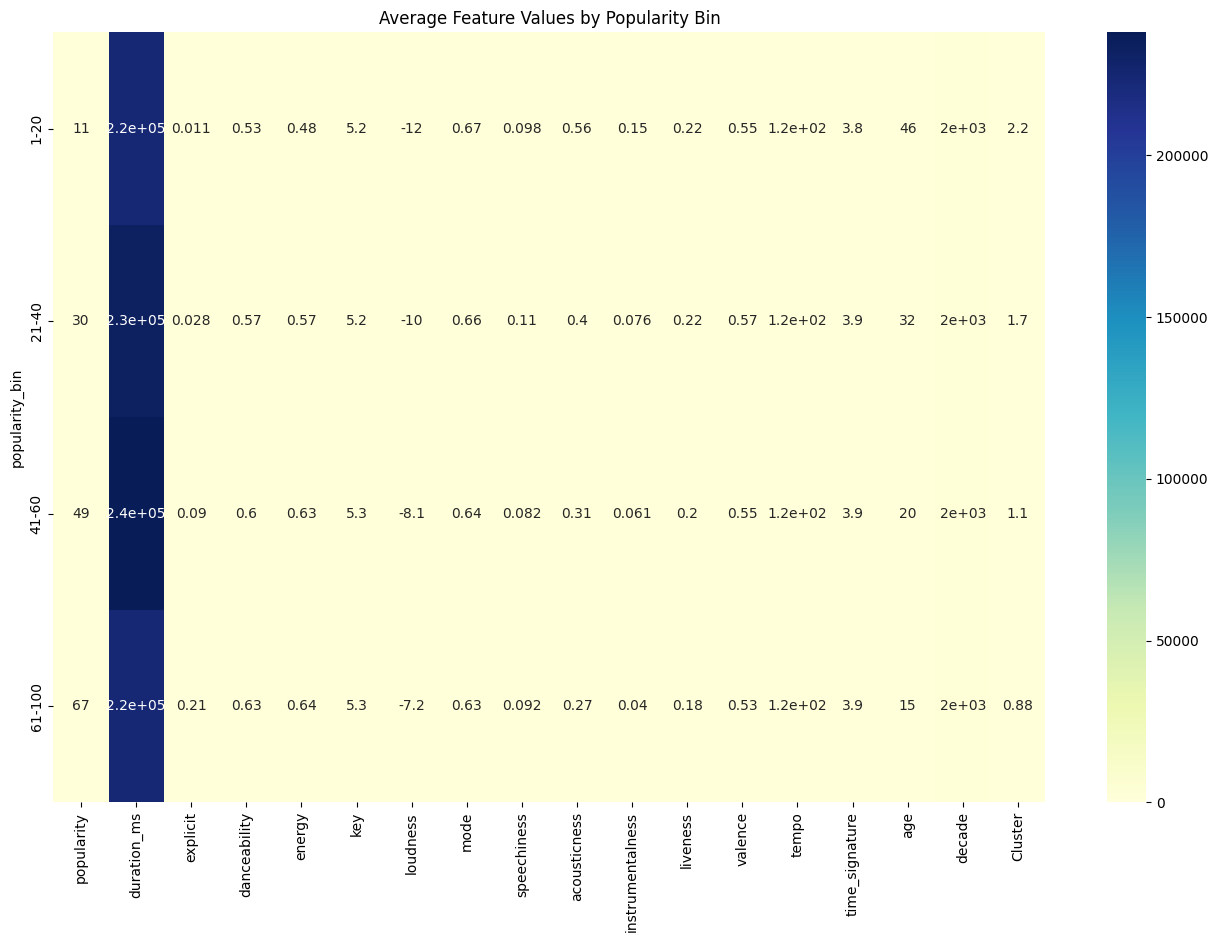

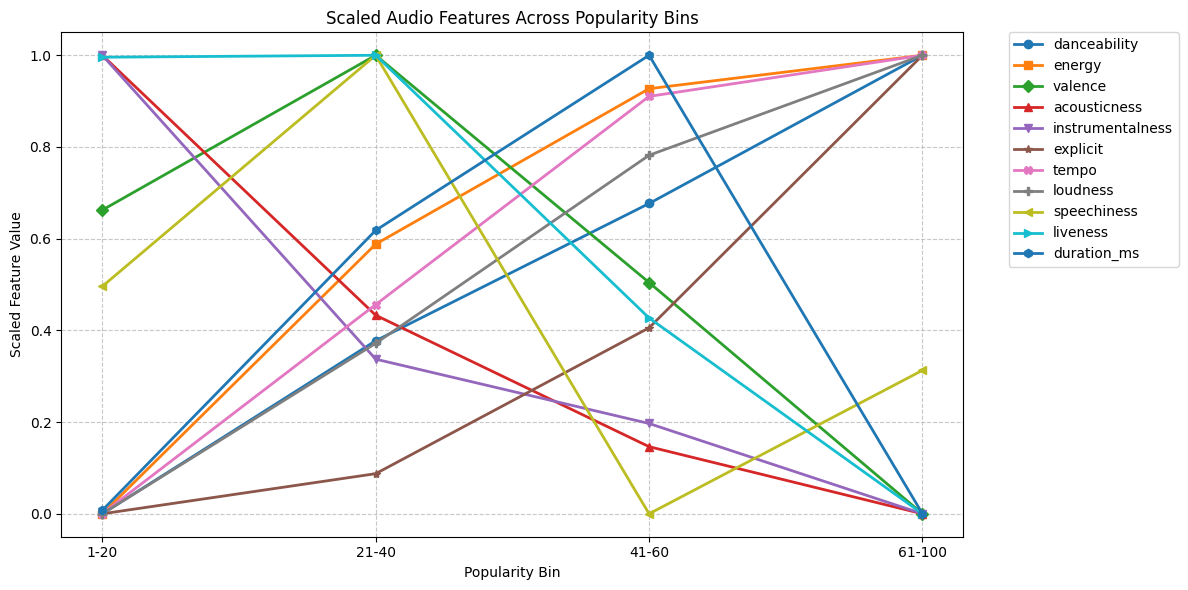

In [26]:
#CELL 11
from sklearn.preprocessing import MinMaxScaler


# Define popularity bins
bins = [0, 20, 40, 60, 100]
labels = ['1-20', '21-40', '41-60', '61-100']

# Create a new column for popularity bins
spotify_with_clusters['popularity_bin'] = pd.cut(
    spotify_with_clusters['popularity'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Remove any rows with NaN popularity_bin (not necessary here)
spotify_with_clusters = spotify_with_clusters.dropna(subset=['popularity_bin'])

# Analyze features by popularity bins
popularity_features = spotify_with_clusters.groupby('popularity_bin').mean()
print("Feature Differences by Popularity Bins:")
print(popularity_features)

# Visualize Feature Differences
plt.figure(figsize=(16, 10))
sns.heatmap(popularity_features, annot=True, cmap='YlGnBu')
plt.title('Average Feature Values by Popularity Bin')
plt.show()

# Keep all existing code first
# [Previous code remains unchanged until after the heatmap]

# Add new visualizations:

# 1. Scale features before plotting the line graph
features_to_plot = [
    'danceability', 'energy', 'valence', 'acousticness', 
    'instrumentalness', 'explicit', 'tempo',  
    'loudness', 'speechiness', 'liveness', 'duration_ms'
]

scaler = MinMaxScaler()
popularity_features_scaled = popularity_features.copy()
popularity_features_scaled[features_to_plot] = scaler.fit_transform(
    popularity_features[features_to_plot]
)

plt.figure(figsize=(12, 6))

# Define a custom color palette
colors = sns.color_palette('tab10', n_colors=len(features_to_plot))

# Optionally, define markers for each line
markers = ['o', 's', 'D', '^', 'v', '*', 'X', 'P', '<', '>', 'h']

for idx, feature in enumerate(features_to_plot):
    plt.plot(
        popularity_features_scaled.index, 
        popularity_features_scaled[feature], 
        marker=markers[idx % len(markers)], 
        label=feature, 
        color=colors[idx % len(colors)],
        linewidth=2
    )
plt.title('Scaled Audio Features Across Popularity Bins')
plt.xlabel('Popularity Bin')
plt.ylabel('Scaled Feature Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

CELL 12: Heatmap of Feature Means per Cluster
Markdown Explanation:
We create a heatmap to visualize how different clusters compare in terms of various features (popularity, danceability, energy, acousticness, instrumentalness, liveness, valence, and age).

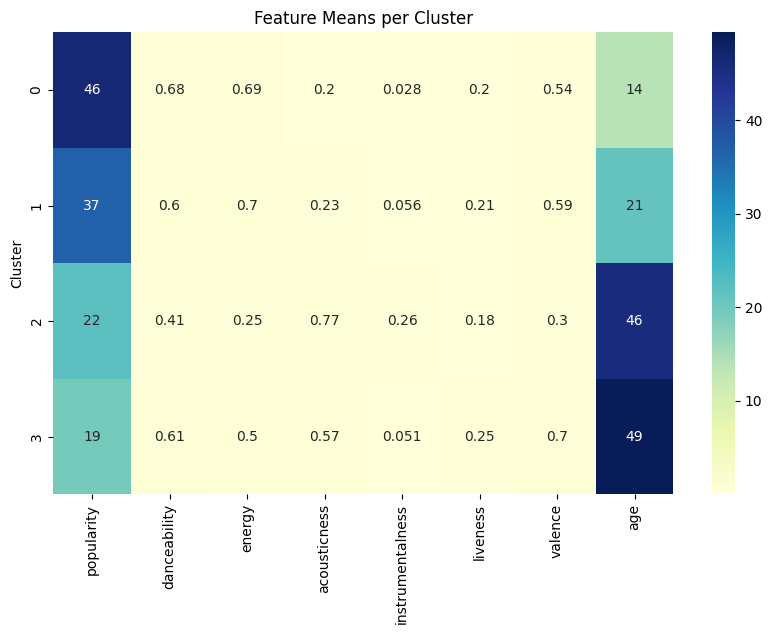

In [27]:
#CELL 12
# Select relevant numeric features
features = ['popularity', 'danceability', 'energy', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'age']

# Calculate cluster means for the specified features
cluster_means = spotify_with_clusters.groupby('Cluster')[features].mean()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu')
plt.title('Feature Means per Cluster')
plt.ylabel('Cluster')
plt.show()

CELL 13: Clustering Evaluation Metrics
Markdown Explanation:
We evaluate the clustering with metrics like the Silhouette Score and the Davies-Bouldin Index to gauge how well our clusters are formed and how distinct they are.

In [28]:
#CELL 13
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Extract features and labels for K-Means
X_kmeans = X_scaled[numerical_cols].copy()
labels_kmeans = X_scaled['Cluster'].values

import numpy as np

# Define sample size
sample_size = 100000
if len(X_kmeans) > sample_size:
    indices = np.random.choice(len(X_kmeans), sample_size, replace=False)
    X_sample = X_kmeans.iloc[indices]
    labels_sample = labels_kmeans[indices]
else:
    X_sample = X_kmeans
    labels_sample = labels_kmeans

silhouette_kmeans = silhouette_score(X_sample, labels_sample)
print(f"Silhouette Score (K-Means): {silhouette_kmeans:.4f}")

dbi_kmeans = davies_bouldin_score(X_sample, labels_sample)
print(f"Davies-Bouldin Index (K-Means): {dbi_kmeans:.4f}")

Silhouette Score (K-Means): 0.1470
Davies-Bouldin Index (K-Means): 2.1410
